# Item Based Recommender System  
-------------
_Author: Carleton Smith_

## Project Guide  
-------------
 - [Project Overview](#project-overview)
 - [Reading in the Data](#read-in)
     - [EDA](#eda)  
       
       
 - [Functioning of Recommender Systems](#simple)
     - [Predicting Unknown Scores](#pred)  
     
     
 - [Return to the Data](#ret)
 - [Utilization Complexities](#util)
 - [SVD](#svd)
 - [Surprise - Python package](#surprise)  
 
 <a id = "project-overview"></a>
 ## Project Overview  
 --------  
 #### EXPECTED TIME: 2.5 HRS  
 
 This project consists of 4 parts:  
 
 - General Familiarization with the data.
 - Mathematical foundations of recommender systems and simple examples about them.
 - Execution of methods on the data.
 - Short introduction to the `Surprise` package.   
 
The methods used below should all be familiar from the lectures in week 9. Except for SVD and the `Surprise` package, we will review some main concepts before demonstration.

The general goal of this project is, given a collection of users, items, and user reviews of the items, predict what score a user would assign to an item they have yet to review.  

We will be working with a synthetic review dataset, modeled on reviews from Amazon. To demonstrate the techniques, in all our examples, we will work only with a smaller portion of the made-up data.

**Motivation:** Recommender systems provide a non-parametric comparisons between items. They are fundamentals in analyzing how individuals can be served.

**Objectives:**  

- Understand mathematical foundations of recommender systems.
- Translation of mathematical algorithm into code.

<a id="questions"></a>
## Questions

+ [Question 01](#q01)
+ [Question 02](#q02)
+ [Question 03](#q03)
+ [Question 04](#q04)
+ [Question 05](#q05)
+ [Question 06](#q06)
+ [Question 07](#q07)
+ [Question 08](#q08)
+ [Question 09](#q09)

### Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

### Reading the data
In the first part of this assignment, we will be using synthetic data modeled from Amazon reviews. A description of the review data and instructions to download the database [can be found here](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).  

Below we display a sample of the data taken from Amazon.

In [21]:
# sample_data_path = "https://s3.amazonaws.com/amazon-reviews-/sample_us.tsv"
sample_data_path = "./data/sample_us.tsv"
# rev_df = pd.read_table(sample_data_path)
rev_df = pd.read_csv(sample_data_path, sep = '\t')
rev_df.head(1)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18778586,RDIJS7QYB6XNR,B00EDBY7X8,122952789,Monopoly Junior Board Game,Toys,5,0,0,N,Y,Five Stars,Excellent!!!,2015-08-31


#### Looking at our raw data

Although Natural Language Processing (NLP) might offer insight into the structure of reviews, for this assignment, we are only interested in the customers (`costumer_id`), the products (`product_id`), and the scores (`star_rating`) that each costumer assigned to a particular product.

In [22]:
##NOTAR QUE ESTE METODO REQUIERE ESPECIFICAR TODAS LAS COLUMNAS EN EL DATAFRAM, MIENTRAS QUE EL METODO <.remane()>
##ES CAPAZ DE RENOMBRAR COLUMNAS ESPECIFICAS, ADEMAS DE QUE PUEDE SER UTILIZADO(A) UN DICCIONARIO O UNA FUNCION 
rev_df = rev_df[['customer_id','product_id', 'star_rating']]
rev_df.columns = ['customer_id', 'product_id', 'score']
rev_df.head()

,customer_id,product_id,score
0,18778586,B00EDBY7X8,5
1,24769659,B00D7JFOPC,5
2,44331596,B002LHA74O,2
3,23310293,B00ARPLCGY,5
4,38745832,B00UZOPOFW,1


In [8]:
rev_df = rev_df[['customer_id','product_id', 'star_rating']]
rev_df.rename(columns= {'star_rating':'score'}, inplace=True)
rev_df.head()

,customer_id,product_id,score
0,18778586,B00EDBY7X8,5
1,24769659,B00D7JFOPC,5
2,44331596,B002LHA74O,2
3,23310293,B00ARPLCGY,5
4,38745832,B00UZOPOFW,1


In [48]:
rev_df['product_id'].count()

49

<a id="q01"></a>
[Return to top](#questions)

### Question 01

Above, in our `ref_df` Database, we used the attribute `rename` to rename the column `star_rating` as `score` by passing a dictionary as a parameter.

Which other object, when passed to `columns`, would have yielded the same result?

- a) "reviewerID, productID, score"
- b) "['asin':'productID','overall':'score']"
- c) "['customer_id', 'product_id', 'score']"
- d) None of the above.

Assign the letter associated with your choice as a string to ans1.

In [23]:
### GRADED
#Which other object, when passed to `columns`, would have yielded the same result?
#a) "reviewerID, productID, score"
#b) "['asin':'productID','overall':'score']"
#c) "['customer_id', 'product_id', 'score']"
#d) None of the above.

#Assign the letter associated with your choice as a string to ans1.
### YOUR SOLUTION HERE
ans1 = 'c'
###
### YOUR CODE HERE
###


In [24]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Although this is not strictly necessary, we can modify the values in columns customer_id and product_id to make them a little easier to read.  

We will do so by building two dictionaries: one for `costumer_id` and the other one for `product_id` in the following way.

Let the keys for your dictionary be all the *n unique* values of `costumer_id`. Rewrite such values to read "R" followed by a number ###, from 0 to n, such that each unique key is mapped to a unique string of the format `R###`. We do the same for the products, but using "P" as a prefix instead.

In [25]:
rID_dict = {rID:'R'+ str(idx) for idx, rID in enumerate(rev_df['customer_id'].unique()) }
pID_dict = {pID:'P'+ str(idx) for idx, pID in enumerate(rev_df['product_id'].unique()) }


### Checking the values in the dictionaries below for products.
for k in list(pID_dict.keys())[:5]:
    print(k, ":",pID_dict[k])
print("length: ",len(pID_dict))

B00EDBY7X8 : P0
B00D7JFOPC : P1
B002LHA74O : P2
B00ARPLCGY : P3
B00UZOPOFW : P4
length:  49


Next, we rename the costumers and products IDs in our dataset.

In [49]:
rev_df.loc[:, 'product_id'] = rev_df.loc[:,'product_id'].map(pID_dict)
rev_df.loc[:, 'customer_id'] = rev_df.loc[:,'customer_id'].map(rID_dict)

rev_df.head()

,customer_id,product_id,score
0,R0,P0,5
1,R1,P1,5
2,R2,P2,2
3,R3,P3,5
4,R4,P4,1


<a id = "Exploratory Data Analysis"></a>
### Exploratory Data Analysis (EDA)
Having gone through the process of cleaning and analyzing the data, we will load a more extensive synthetic dataset and perform some light EDA to look at the distributions of the data.

In [50]:
# Reading the data
synth_data_path = "./data/synthetic_reviews.csv"

rev_df = pd.read_csv(synth_data_path)
rev_df.head()

,reviewerID,productID,score
0,R0,P6181,5
1,R0,P2276,2
2,R0,P1382,5
3,R0,P4797,5
4,R0,P281,1


First, we visualize how many products got a score of 5, 4, 3, 2, or 1. 

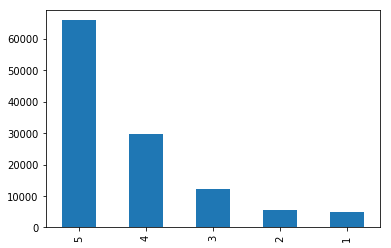

In [51]:
rev_df['score'].value_counts().plot(kind = 'bar');

Next, we count how many products received a specific score.

In [52]:
rev_df['score'].value_counts()

5    65826
4    29717
3    12352
2     5604
1     4981
Name: score, dtype: int64

We notice that there is an interesting preponderance of products with score 5. 

We continue by ranking the product from the ones that had the most reviews to the ones that had the least. We display the first 15 and the last 5 rows of this ranking.

In [58]:
rev_df['productID'].value_counts().value_counts().head()

6    479
7    459
5    403
8    377
9    377
Name: productID, dtype: int64

In [59]:
rev_df['productID']

0         P6181
1         P2276
2         P1382
3         P4797
4          P281
5         P5556
6         P1523
7         P4693
8         P5494
9         P2245
10        P4534
11        P5629
12         P198
13        P2800
14        P5296
15        P5179
16        P5252
17        P2850
18          P36
19        P5214
20        P6225
21        P3668
22        P3584
23        P3469
24        P4391
25        P5113
26        P2210
27        P1073
28        P5693
29        P3523
          ...  
118450    P4888
118451    P5862
118452    P1942
118453    P4816
118454     P502
118455    P2489
118456    P2348
118457    P3649
118458    P6371
118459    P1408
118460    P5657
118461    P3607
118462    P2662
118463    P3178
118464    P3938
118465     P666
118466    P2582
118467    P1621
118468    P3990
118469    P1463
118470    P1543
118471    P2553
118472    P4151
118473    P6191
118474     P890
118475    P5487
118476    P3461
118477    P3436
118478     P540
118479    P6311
Name: productID, Length:

In [53]:
print("Reviews per product, top and bottom reviewed\n")
#Display first 15 rows
print(rev_df['productID'].value_counts()[:15])
#Display last 5 rows
print(rev_df['productID'].value_counts()[-5:])

Reviews per product, top and bottom reviewed

P4407    302
P6092    290
P677     264
P4492    250
P1099    210
P2535    191
P1959    190
P4597    189
P3829    188
P2214    184
P3579    183
P540     180
P2245    178
P3437    176
P3342    172
Name: productID, dtype: int64
P3174    1
P2598    1
P4911    1
P2363    1
P3       1
Name: productID, dtype: int64


Below, we visualize the ranking defined above.

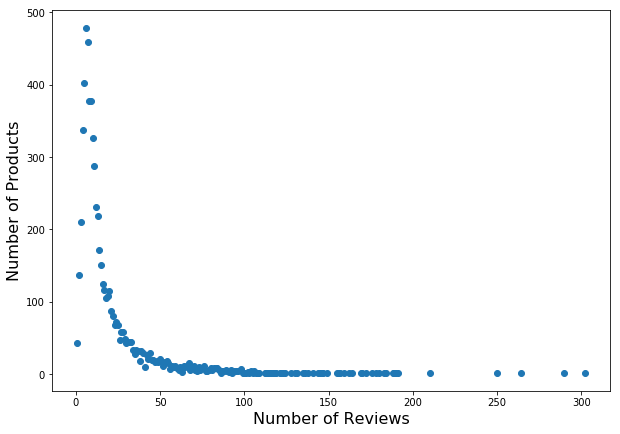

In [54]:
product_w_n_reviews = rev_df['productID'].value_counts().value_counts()
plt.figure(figsize = (10,7))
plt.scatter(product_w_n_reviews.index, product_w_n_reviews)
plt.xlabel("Number of Reviews", fontsize = 16)
plt.ylabel("Number of Products", fontsize = 16);

The above graph seem to be on a log-normal scale. 

In reality, the graph displayed has the shape of a "hollow curve". The log-normal appearance is an artifact of the data synthesis.

We will continue our EDA by ranking which costumers gave the most and least number of reviews.

In [60]:
print("Reviews per reviewer, top and bottom reviewers\n")
print(rev_df['reviewerID'].value_counts()[:15])
print(rev_df['reviewerID'].value_counts()[-5:])

Reviews per reviewer, top and bottom reviewers

R8577    578
R8247    578
R2603    375
R3429    375
R4759    375
R9317    301
R1396    301
R3559    261
R830     256
R8531    256
R8114    246
R6324    246
R4022    246
R6339    246
R4749    200
Name: reviewerID, dtype: int64
R2676    5
R3594    5
R1124    5
R2028    5
R2926    5
Name: reviewerID, dtype: int64


Again, we visualize the ranking defined above.

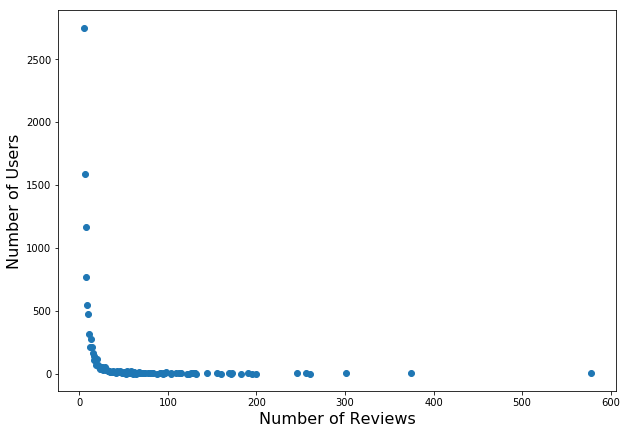

In [61]:
product_w_n_reviews = rev_df['reviewerID'].value_counts().value_counts()
plt.figure(figsize = (10,7))
plt.scatter(product_w_n_reviews.index, product_w_n_reviews)
plt.xlabel("Number of Reviews", fontsize = 16)
plt.ylabel("Number of Users", fontsize = 16);

As expected, most products are only reviewed a few times, most users only submit a few reviews, and very few users have submitted many reviews. 

Again. the above graph has the shape of a "hollow curve".

<a id = "simple"></a>
### Functioning of Recommender Systems

Before tackling our extensive synthetic data, we will use a simpler dataset to demonstrate the functioning of recommender systems.  

Below we have a set of rankings of six musicians made by six individuals.  

In [62]:
example_path = "./data/example.csv"
ex = pd.read_csv(example_path, index_col = 0)
ex

,Mozart,Bach,Chopin,Brahms,Wagner,Liszt
Abel,0,1,2,2,1,3
Baker,5,0,3,2,3,3
Charlie,5,4,0,5,3,2
David,5,5,5,0,2,1
Erik,3,3,4,3,0,2
Frank,2,2,1,1,3,0


Note that the value "0" in the rows above denotes the absence of ranking - NOT an extremely poor ranking.  

To determine which product to recommend, we can compute the similarity scores between products. Similarity scores can be computed in three different ways:

- the Euclidean distance,
- the Pearson's correlation coefficient,
- and the cosine similarity score. 

To compare these scores we will normalize each to range between 0 and 1.  
To simplify our analysis, we will use a subset of our example DataFrame:

In [63]:
ex_hand = ex.iloc[:3,-3:]
ex_hand

,Brahms,Wagner,Liszt
Abel,2,1,3
Baker,2,3,3
Charlie,5,3,2


#### Euclidean Distance

The Euclidean distance between and point $i =(a_i, b_i, \dots, n_i)$ and $j= (a_j, b_j, \dots, n_j)$ is given by

$$\sqrt{(a_j-a_i)^2+(b_j-b_i)^2+...+(n_j-n_i)^2}$$  


<a id="q02"></a>
[Return to top](#questions)
### Question 02

Calculate the Euclidean distance between Brahms and Wagner in the `ex_hand` DataFrame. 


Assign the computed distance as a float to the variable ans2. Make sure that is answer is accurate to 3 decimal places. Feel free to use the KNN assignment as a reference.


In [66]:
def dis_euc(v1,v2):
    sqr_diff = [(xi - xj)**2 for xi,xj in zip(v1,v2)]
    dist = np.sqrt(sum(sqr_diff))
    return dist

In [72]:
brahms = ex_hand['Brahms'].values
wagner = ex_hand['Wagner'].values
round(dis_euc(brahms,wagner),3)

2.449

In [73]:
1/(1+2.449)

0.2899391127863149

In [74]:
### GRADED
# Calculate the Euclidean distance between Brahms and Wagner in the `ex_hand` DataFrame
# Assign the computed distance as a float to the variable ans2. Make sure that is answer is 
# accurate to 3 decimal places. Feel free to use the KNN assignment as a reference.
### YOUR SOLUTION HERE

ans2 = 2.449
###
### YOUR CODE HERE
###


In [75]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


To normalize the Euclidean distance between 0 and 1, we can use the following formula that relates "distance" to "similarity"

$$\text{similarity} =\frac1{1+\text{distance}}.$$

For example, a distance of 0 corresponds to a similarity of 1, and a very large distance (e.g., $\infty$) corresponds to a similarity of 0.  

<a id="q03"></a>
[Return to top](#questions)
### Question 03

Define a  function called `e_sim` that accepts two `pandas` series as arguments.

Your function should return the euclidean similarity score between the two series. Make sure that is answer is accurate to 3 decimal places.

For this question you will need to use the attribute `np.linalg.norm()`.

In [76]:
def e_sim(ser1, ser2):
    sqr_diff = [(xi - xj)**2 for xi,xj in zip(ser1,ser2)]
    distance = np.sqrt(sum(sqr_diff))
    similarity = 1 / (1 + distance)
    return similarity

In [77]:
ser1 = ex_hand.iloc[:,0]
ser2 = ex_hand.iloc[:,1]
print(e_sim(ser1, ser2)) #--> 0.28989794855663564

0.28989794855663564


In [78]:
### GRADED
# Define a  function called `e_sim` that accepts two `pandas` series as arguments.
# Your function should return the euclidean similarity score between the two series. 
# Make sure that is answer is accurate to 3 decimal places.

# For this question you will need to use the attribute `np.linalg.norm()`.
### YOUR SOLUTION HERE

def e_sim(ser1, ser2):
    """
    Given two Pandas series, compute the euclidean similarity score;
        1 / 1+euclidean distance
        
    Positional Arguments --
        ser1: a Pandas Series of length n
        ser2: a Pandas Series of length n
    
    Example --
        ser1 = ex_hand.iloc[:,0]
        ser2 = ex_hand.iloc[:,1]
        print(e_sim(ser1, ser2)) #--> 0.28989794855663564
    """
    sqr_diff = [(xi - xj)**2 for xi,xj in zip(ser1,ser2)]
    distance = np.sqrt(sum(sqr_diff))
    similarity = 1 / (1 + distance)
    return similarity
###
### YOUR CODE HERE
###

In [79]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Pearson's Correlation Coefficient

The Pearson's correlation coefficient $\rho$ takes values from -1 to 1. Therefore, to normalize it into a difference score between 0 and 1, we need to reduce that range by half (i.e., divide the range by two) to increase the minimum score to 0, and add .5:  

$$\frac12 + \frac{\rho_{xy}}2$$  

The function below computes the Pearson's correlation coefficient.

In [80]:
### Function to define the Pearson's Correlation Coefficient.
def p_sim(ser1, ser2):
    
    def normalize(raw):
        return .5 + (raw/2)
    
    corr = np.corrcoef(ser1, ser2)[0][1] ### returns 2x2 array with correlation to self(1) on diagonal
    
    return normalize(corr)

In [85]:
ser1 = ex_hand.iloc[:,0]
ser2 = ex_hand.iloc[:,1]
print(p_sim(ser1, ser2))
np.corrcoef(ser1, ser2)[0][1]

0.75


0.5000000000000001

#### Cosine Similarity

The cosine similarity calculates the cosine of the angle between two vectors normalizing it between 0 and 1.  

<a id="q04"></a>
[Return to top](#questions)
### Question 04

Decide whether the following statement is true or false.

*Like the correlation coefficient similarity score, the cosine similarity score is unaffected by magnitudes. For example, an excited user who gives mostly 5's will be considered similar to a user who gives mostly 2's.*

Assign a Boolean value to the variable ans1.

In [86]:
### GRADED
#Decide whether the following statement is true or false.

#*Like the correlation coefficient similarity score, the cosine similarity score is 
# unaffected by magnitudes. For example, an excited user who gives mostly 5's will be 
# considered similar to a user who gives mostly 2's.*

#Assign a Boolean value to the variable ans1.
### YOUR SOLUTION HERE

ans1 = True
###
### YOUR CODE HERE
###


In [87]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


The cosine similarity score is given by the following formula

$$cos(\theta) = \frac{S1\cdot S2}{||S1||\cdot||S2||},$$
 
 where $S1$ and $S2$ are the two vectors considered, and $||\cdot||$ represents the magnitude of each vector.
 
The function below computes the cosine similarity score.

In [88]:
###Function to define the cosine similarity.

def c_sim(ser1, ser2):
    def normalize(raw):
        return .5 + (raw/2)
    
    cosT = np.dot(ser1, ser2) / (np.linalg.norm(ser1)* np.linalg.norm(ser2))
    
    return normalize(cosT)

In [91]:
ser1 = ex_hand.iloc[:,0]
ser2 = ex_hand.iloc[:,1]
print(c_sim(ser1, ser2))
np.dot(ser1, ser2) / (np.linalg.norm(ser1)* np.linalg.norm(ser2))

0.9592657617027512


0.9185315234055025

At this point we have defined three functions for calculating similarity between two vectors.  

- e_sim: for the Euclidean similarity 
- p_sim: for the Pearson correlation coefficient similarity
- c_sim: for the cosine similarity
 

Now, let's calculate each of the three similarity scores for each pair of musicians in the `ex` DataFrame.  

Let's remind us of what the DataFrame `ex` looks like.

In [92]:
ex

,Mozart,Bach,Chopin,Brahms,Wagner,Liszt
Abel,0,1,2,2,1,3
Baker,5,0,3,2,3,3
Charlie,5,4,0,5,3,2
David,5,5,5,0,2,1
Erik,3,3,4,3,0,2
Frank,2,2,1,1,3,0


The function we will build must take into account that not all users have rated all musicians.

So, for example, when comparing "Mozart" and "Bach", we must disregard the observations from "Abel" and "Baker", respectively.  

This can be done by reading the value "0" as to be "less than 1", and *not* as the lack of information which actually represents.  


<a id="q05"></a>
[Return to top](#questions)
### Question 05
Define a  function called `drop_val` that accepts the following  arguments:

- A `pandas` DataFrame.
- A numeric variable named `to_drop`.

Your function should drop all the rows that have the value contained in `to_drop` in any column, and should return the DataFrame without the rows that have been dropped.

For example, if we pass the DataFrame `ex` containing all rows but only the columns corresponding to "Mozart" and "Bach", and we set  'to_drop=5', our function should return "Abel", "Erik", and "Frank" rows with all the original columns. 

In [107]:
def drop_val (df, to_drop):
    for col in df.T:
        if to_drop in df.T[col].unique():
            df = df.drop(col)
            
    return df    

In [114]:
df = ex.loc[:,"Mozart":"Bach"]
to_drop = 0
print(drop_val(df,to_drop)) # -->          Mozart  Bach
#                                 Abel        0     1
#                                 Erik        3     3
#                                 Frank       2     2   
# for col in df.T:
#     print(df.T[col].unique())

         Mozart  Bach
Charlie       5     4
David         5     5
Erik          3     3
Frank         2     2


In [116]:
##REGRESA LOS INDICES (ROWS) QUE NO CONTENGAN VALORES CERO ...
## array([2, 3, 4, 5], dtype=int64)
np.intersect1d( df.iloc[:,0].to_numpy().nonzero(), df.iloc[:,1].to_numpy().nonzero())
df.iloc[np.intersect1d( df.iloc[:,0].to_numpy().nonzero(), df.iloc[:,1].to_numpy().nonzero())]

,Mozart,Bach
Charlie,5,4
David,5,5
Erik,3,3
Frank,2,2


In [109]:
### GRADED
#Define a function called drop_val that accepts the following arguments:
# - A pandas DataFrame.
# - A numeric variable named to_drop.

# Your function should drop all the rows that have the value contained in to_drop in any column, 
# and should return the DataFrame without the rows that have been dropped.

# For example, if we pass the DataFrame ex containing all rows but only the columns corresponding
# to "Mozart" and "Bach", and we set 'to_drop=5', our function should return "Abel", "Erik", and "Frank" 
# rows with all the original columns.
### YOUR SOLUTION HERE

def drop_val (df, to_drop):
    
    """
    Drop rows from the DataFrame containing the specified values
    
    Positional Arguments --
        df: a Pandas DataFrame
        to_drop: a value found in some rows of df
    
    Example --
        
        df = ex.loc[:,"Mozart":"Bach]
        to_drop = 5
        print(drop_val(df,to_drop)) # -->          Mozart  Bach
                                            Abel        0     1
                                            Erik        3     3
                                            Frank       2     2   
    """
    for col in df.T:
        if to_drop in df.T[col].unique():
            df = df.drop(col)
            
    return df
###
### YOUR CODE HERE
###

In [110]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


The cell below defines a function "drop_rows_with_zeros" that takes a DataFrame with two columns and returns a DataFrame where all the rows that contain a value of 0 have been removed.

In [111]:
### Defining drop_rows_with_zeros

def drop_rows_with_zeros(df):
    keep = np.intersect1d( df.iloc[:,0].to_numpy().nonzero(), df.iloc[:,1].to_numpy().nonzero())
    
    return df.iloc[keep,:]


### Comparison of Similarity Scores

Below, we will compare the similarity scores for each each combination of musicians. 

First, we find all the possible pairs of musicians:

In [117]:
import itertools
for c in itertools.combinations(ex.columns,2):
    print(c)

('Mozart', 'Bach')
('Mozart', 'Chopin')
('Mozart', 'Brahms')
('Mozart', 'Wagner')
('Mozart', 'Liszt')
('Bach', 'Chopin')
('Bach', 'Brahms')
('Bach', 'Wagner')
('Bach', 'Liszt')
('Chopin', 'Brahms')
('Chopin', 'Wagner')
('Chopin', 'Liszt')
('Brahms', 'Wagner')
('Brahms', 'Liszt')
('Wagner', 'Liszt')


Each tuple can be used as a subset in the DataFrame. For example, the subset for Mozart and Bach is given by:

In [118]:
ex[list(('Mozart', 'Bach'))]

,Mozart,Bach
Abel,0,1
Baker,5,0
Charlie,5,4
David,5,5
Erik,3,3
Frank,2,2


Next, we define a first dictionary that has as keys the pairs musicians being compared.

In a second dictionary, we define the similarity scores, "Euclid", "Pearson", and "Cosine",  corresponding to each pair of musician.

In [119]:
sim_scores = dict()

for c in itertools.combinations(ex.columns, 2):
    df = drop_rows_with_zeros(ex[list(c)])
    ser1 = df.iloc[:,0]
    ser2 = df.iloc[:,1]
    scores = {"Euclid":e_sim(ser1, ser2), "Pearson":p_sim(ser1,ser2), "Cosine":c_sim(ser1,ser2)}
    key =", ".join(c)
    sim_scores[key] = scores
    
sims = pd.DataFrame.from_dict(sim_scores,orient = "index")
sims

,Euclid,Pearson,Cosine
"Bach, Brahms",0.366025,0.915761,0.982382
"Bach, Chopin",0.366025,0.927618,0.983997
"Bach, Liszt",0.166667,0.021909,0.863054
"Bach, Wagner",0.231662,0.690693,0.945785
"Brahms, Liszt",0.224009,0.091752,0.923659
"Brahms, Wagner",0.240253,0.596225,0.921332
"Chopin, Brahms",0.414214,0.974342,0.994881
"Chopin, Liszt",0.179129,0.028060,0.897253
"Chopin, Wagner",0.210897,0.423553,0.900668
"Mozart, Bach",0.500000,0.973365,0.997200


The similarity scores can be visualized as follow

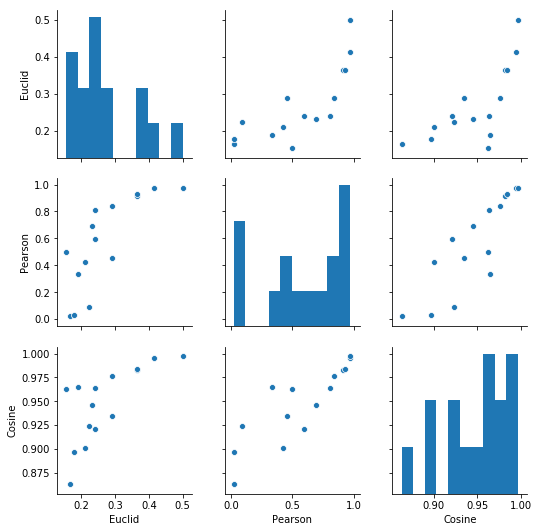

In [120]:
### Note: x and y scales are not consistent in this visualization
sns.pairplot(sims );

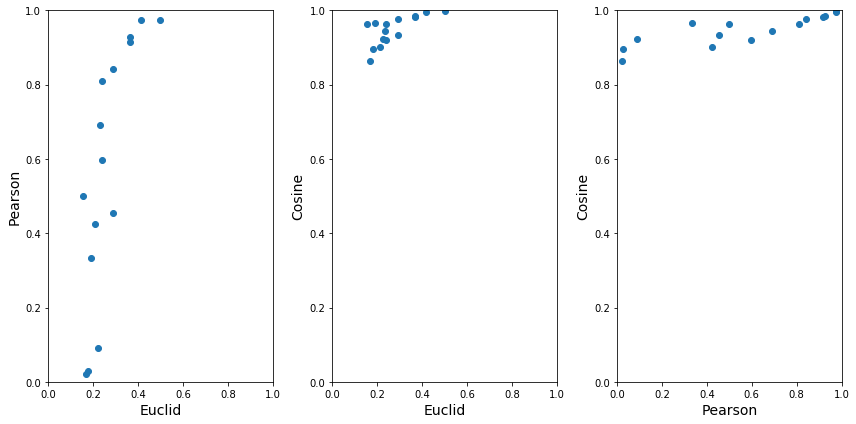

In [121]:
### Visualization with consistent x and y scales using `matplotlib`
plt.figure(figsize = (12,6))
for i, cols in enumerate([('Euclid','Pearson'), ("Euclid","Cosine"),("Pearson","Cosine")]):
    plt.subplot(1,3,i+1)
    
    plt.scatter(sims[cols[0]], sims[cols[1]])
    
    plt.xlabel(cols[0], fontsize = 14); plt.ylabel(cols[1], fontsize = 14)
    plt.xlim(0,1); plt.ylim(0,1)
    
plt.tight_layout()

<a id = "sim-note"></a>
#### Differences in Similarity Scores


As we can see from the graphs above, it is possible to visualize a range of similarity scores given different techniques. These similarity scores will majorly impact how a recommender system performs. 

Refer to the lectures for the particular impacts and strengths of the different similarity calculations.

<a id = 'pred'></a>
### Predicting Unknown Scores

Assume that we don't know the score that Abel gave to Mozart. To do so, we must take into account that Mozart has a similarity score in relation to all the other musicians.

Similarly, Abel has given a score to all the other musicians.  

Therefore, Abel's predicted score for Mozart will be given by: the **sum** of Abel's score for every other musician **times** that musician's similarity score with respect to Mozart, **divided by** the sum of similarity scores.  

For example, we can predict Abel's score for Mozart by computing

$$\frac{\sum_{ mus = Bach}^{Liszt}A_{mus}*\text{simScore}(\text{Mozart, mus})}{\sum_{mus = Bach}^{Liszt}\text{simScore}{\text{(Mozart, mus)}}}$$ 

The commands below compute the similarity scores for Mozart.

In [125]:
def score_predict(df, person, simScore):
    sScore = []
    pScore = []
    
    for key in simScore:
        ss = simScore[key]
        sScore.append(ss)
        pScore.append(df.loc[person,key] * ss)
        
    prediction = sum(pScore)/sum(sScore)
    return prediction

In [122]:
drop_rows_with_zeros(ex.iloc[:, :6])

,Mozart,Bach,Chopin,Brahms,Wagner,Liszt
Charlie,5,4,0,5,3,2
David,5,5,5,0,2,1
Erik,3,3,4,3,0,2
Frank,2,2,1,1,3,0


In [124]:
for mus in ex.columns[1:]:
    no_zeros = drop_rows_with_zeros(ex[['Mozart', mus]])
no_zeros

,Mozart,Liszt
Baker,5,3
Charlie,5,2
David,5,1
Erik,3,2


In [123]:
mozSimScores = {}
for mus in ex.columns[1:]:
    no_zeros = drop_rows_with_zeros(ex[['Mozart', mus]])
    
    mozSimScores[mus] = round(p_sim(no_zeros.iloc[:,0], no_zeros.iloc[:,1]),2)

print(mozSimScores)

{'Bach': 0.97, 'Chopin': 0.84, 'Brahms': 0.81, 'Wagner': 0.33, 'Liszt': 0.5}


<a id="q06"></a>
[Return to top](#questions)
### Question 06

Given the similarity scores calculated and stored in `mozSimScores`, use the above formula to predict Abel's score for Mozart. Assign your result to the variable ans1.Make sure that is answer is accurate to 3 decimal places.

*Hint*: Use the rounded score computed above.

In [127]:
round(score_predict(ex,'Abel',mozSimScores),3)

1.768

In [128]:
### GRADED
# Given the similarity scores calculated and stored in `mozSimScores`, use the above 
# formula to predict Abel's score for Mozart. Assign your result to the variable ans1.
# Make sure that is answer is accurate to 3 decimal places.


# *Hint*: Use the rounded score computed above.

###  YOUR SOLUTION HERE
def score_predict(df, person, simScore):
    sScore = []
    pScore = []
    
    for key in simScore:
        ss = simScore[key]
        sScore.append(ss)
        pScore.append(df.loc[person,key] * ss)
        
    prediction = sum(pScore)/sum(sScore)
    return prediction

ans1 = round(score_predict(ex,'Abel',mozSimScores),3)
###
### YOUR CODE HERE
###


In [129]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


We observe that, although many other users gave Mozart high scores, because Abel appears to be less generous in his reviews, his predicted score for Mozart is fairly low. 

The function defined below predicts an unknown score based on the formula above.

In [130]:
### Creating a function to create predictions in the manner described above.
### Note: "user" is a row, and "item" is a column in the df.
### simFunc defaults to p_sim

def scorePred(df, user, item, simFunc = p_sim, rev_items = None):
    """
    Positional Arguments --
        df: Pandas DataFrame
        user: Row-index in df
        item: Column-index in df
        simFunc: a similarity function (e_sim, p_sim, or c_sim)
        rev_items: For larger dfs, specifies all items reviewed by "user"
    """
    # Check to see if user has already scored item
    if df.loc[user,item] > 0:
        return "Already rated a "+str(df.loc[user,item])
    
    # rev_items used for larger DataFrame,
    # when you have all the items a particular user has reviewed already
    # otherwise, if "None" (if statement below)
    # take all other items other than item to predict
    if not rev_items:
        rev_items = set(df.columns)
        rev_items.remove(item)
    
    sim_total, user_sim_total = 0,0
    
    for other_item in rev_items:
        user_score_other_item = df.loc[user, other_item] # grab user score
        
        if user_score_other_item == 0:
            print("no user score")
            continue
        
        # Use function built above to drop all other users with "other_item" score of "0"
        no_zeros = drop_rows_with_zeros(df[[item, other_item]]) 
        sh = no_zeros.shape
        
        # If no other users, move to next item
        if sh[0] == 0:
            continue
            
        #print(no_zeros.shape)
        
        # calculate similarity score using non-zero information. 
        ser1 = no_zeros.iloc[:,0]
        ser2 = no_zeros.iloc[:,1]
        # print(ser1, ser2)
        ss = simFunc(no_zeros.iloc[:,0], no_zeros.iloc[:,1])
        # print(ss, user_score_other_item)
        
        # add up sim total and weighted sim total
        sim_total += ss
        user_sim_total += user_score_other_item * ss

        
    if sim_total == 0:
        return 0
    
    else:
        return user_sim_total / sim_total

In [131]:
ex

,Mozart,Bach,Chopin,Brahms,Wagner,Liszt
Abel,0,1,2,2,1,3
Baker,5,0,3,2,3,3
Charlie,5,4,0,5,3,2
David,5,5,5,0,2,1
Erik,3,3,4,3,0,2
Frank,2,2,1,1,3,0


Use the cells below to compute the unknown score for different cases using the function `scorePred` defined above.

In [132]:
scorePred(ex, 'Baker', 'Bach')

3.292113254792299

<a id = "ret"></a>
### Returning to the Data
Let's go back to the Amazon rating DataFrame

In [133]:
rev_df.head(10)

,reviewerID,productID,score
0,R0,P6181,5
1,R0,P2276,2
2,R0,P1382,5
3,R0,P4797,5
4,R0,P281,1
5,R0,P5556,5
6,R0,P1523,4
7,R0,P4693,4
8,R0,P5494,5
9,R0,P2245,5


We observe that now the data does not conform to the two-dimensional n-by-p matrix that we have been using. Therefore, we need to manipulate our data. To do so we will use `Pandas` built-in `pivot()` attribute.

In [134]:
# Reviewers on rows, item on cols. 
reshaped_reviews = rev_df.pivot(index = 'reviewerID', columns = 'productID')
reshaped_reviews.fillna(0, inplace = True) # turns NA into 0
reshaped_reviews.columns = reshaped_reviews.columns.droplevel() # removes artifact of pivot function


print("shape: ", reshaped_reviews.shape)
reshaped_reviews.head()

shape:  (10000, 6411)


productID,P0,P1,P10,P100,P1000,P1001,P1002,P1003,P1004,P1005,...,P990,P991,P992,P993,P994,P995,P996,P997,P998,P999
reviewerID,,,,,,,,,,,,,,,,,,,,,
R0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It should be clear from the output above that the majority of the entries corresponding to a certain pair of costumer and product are now empty. Thus, when trying to provide recommendations, it will not be possible to predict scores for every  combination of costumer and product. In fact, to predict scores, we require a certain amount of overlap between the data.

Below predictions are created for our reviewer called "R0"

In [135]:
### First, find the products that 'R0' has reviewed.
### These are the products that will be used for creating similarity scores.

r0 = reshaped_reviews.loc["R0", :]
# numpy function returns all indexes that are not "0"
r0_nonzero = r0.to_numpy().nonzero()
# collect names of reviewed products
r0_rev_prods = list(r0.iloc[r0_nonzero].index) 
print(len(r0_rev_prods))
r0_rev_prods[:5]

20


['P1382', 'P1523', 'P198', 'P2245', 'P2276']

Next, we create a list containing the product that have not been reviewed by R0.

In [136]:
### Creating a list of products not reviewed by R0

# return list of all prods not in the "reviewed" list
r0_not_rev = np.setdiff1d(reshaped_reviews.columns, r0_rev_prods) 

print(len(r0_not_rev))
r0_not_rev

6391


array(['P0', 'P1', 'P10', ..., 'P997', 'P998', 'P999'], dtype=object)

The commands below require too much processing for Vocareum. 
```python
### predict scores for products not yet reviewed by R0, using function built above: `scorePred`
### cosine similarity used because if a product all has only one value of review (e.g. all 5s)
### then the standard_deviation is 0 and the correlation coefficient is not calculable

preds = {}
for item in r0_not_rev:
   preds[item] = scorePred(reshaped_reviews, 'R0', item, simFunc = c_sim, rev_items = r0_rev_prods)

pd.Series(preds).sort_values(ascending = False).head(10)
```
We simply display the output below:

```
P470     5.0
P2342    5.0
P4839    5.0
P4796    5.0
P2703    5.0
P4800    5.0
P615     5.0
P4806    5.0
P2699    5.0
P1533    5.0
dtype: float64
```

<a id = "util"></a>
### Utilization Complexities

Certainly, if  a product is likely to score a "5", then that product should be recommended. However, because we are dealing with very sparse data, the confidence in our predictions will vary between each product.

<a id="q07"></a>
[Return to top](#questions)
### Question 07

Consider 3 products: `A`, `B`, and `X`. Assume that `userN` has ranked both products `A`, and `B` with a score of 5. Assume that `user1` has ranked products `A`, and `X` both with score 3 and assume that user2 has ranked products `B` and `X` with score 2.

What will be the similarity score between product `A` and product `X`? Assign the result the the variable ans1.

What will be the similarity score between product `B` and product `X`? Assign the result the the variable ans2.


In [141]:
a = np.array([5, 3])
b = np.array([5, 2])
x = np.array([3, 2])

p_sim(b, x)

1.0

In [142]:
### GRADED
# Consider 3 products: `A`, `B`, and `X`. Assume that `userN` has ranked both products `A`, and `B` 
# with a score of 5. Assume that `user1` has ranked products `A`, and `X` both with score 3 and assume 
# that user2 has ranked products `B` and `X` with score 2.

# What will be the similarity score between product `A` and product `X`? Assign the result the the variable ans1.

#What will be the similarity score between product `B` and product `X`? Assign the result the the variable ans2.
### YOUR SOLUTION HERE

ans1 = 1.0
ans2 = 1.0
###
### YOUR CODE HERE
###


In [143]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


<a id="q08"></a>
[Return to top](#questions)
### Question 08

Given your answer above, what will be the predicted score of `userN` for product `X`?

Assign your result to the variable ans1.

In [144]:
### GRADED
#Given your answer above, what will be the predicted score of `userN` for product `X`?

#Assign your result to the variable ans1.
###  YOUR SOLUTION HERE
ans1 = 5
###
### YOUR CODE HERE
###


In [145]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


it is important to note that we could have run into other possible scenarios: high similarity scores because of few overlapping reviews, or high-user score for the user who is being predicted for.  

<a id = "svd"></a>
### Singular Value Decomposition (SVD)

We can deal with the sparsity of data and, at the same time, increase the speed of our algorithm,  by using Singular Value Decomposition (SVD). SVD is a technique that reduces the dimensionality of functions by "capturing" a majority of the information present in a dataset in a smaller number of variables.  

SVD relies upon some straight-forward linear algebra that is worth understanding. The main concept have been covered  in the lectures. Here are some more insightful resources about SVD.  

[Here is a nice introduction.](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/)  

[Below, we will use `numpy's` implementation of SVD](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html)

We have learned that the quantity $\Sigma ^2$ describes the variance of each vector. The plot below displays the rate of the variance given by n vectors as a function of the total number of products.

![svd](./assets/svd.PNG)

We notice that about 1700 of the decomposed vectors will give around 80% of the variance in the data. Computationally, this will make the calculations much faster: in fact, considering only 1/3 of the vectors will yield 80% of the value. 

In [146]:
reshaped_reviews.shape

(10000, 6411)

In [147]:
u, sigma, _ = np.linalg.svd(reshaped_reviews)

In [148]:
def return_svd(df , u, sigma, n):
    sigN = np.mat(np.eye(n) * sigma[:n]) #arrange Sig4 into a diagonal matrix
    n_svd_vectors = np.dot(df.T, np.dot(u[:,:n] , sigN.I))  #create transformed items
    return pd.DataFrame(n_svd_vectors).T

The commands below take too long to run for Vocareum. 
```python
# Perform SVD
u, sigma, _ = np.linalg.svd(reshaped_reviews)

# Create function to decompose DataFrame
def return_svd(df , u, sigma, n):
   sigN = np.mat(np.eye(n) * sigma[:n]) #arrange Sig4 into a diagonal matrix
   n_svd_vectors = np.dot(df.T, np.dot(u[:,:n] , sigN.I))  #create transformed items
   return pd.DataFrame(n_svd_vectors).T

# use function to create decomposed DataFrame
svd_df = return_svd(reshaped_reviews, u, sigma, 1700)
svd_df.columns = reshaped_reviews.columns

# Save DataFrame

svd_df.to_csv("svd_df.csv")
```
The results are loaded below:

In [149]:
svd_df = pd.read_csv("./data/svd_df.csv", index_col = 0)
svd_df.head()

,P0,P1,P10,P100,P1000,P1001,P1002,P1003,P1004,P1005,...,P990,P991,P992,P993,P994,P995,P996,P997,P998,P999
0,-0.00455,-0.00678,-0.00358,-0.00071,-0.01071,-0.00035,-0.00479,-0.00499,-0.01016,-0.01439,...,-0.00098,-0.00436,-0.00476,-0.00412,-0.00055,-0.00966,-0.00911,-0.04709,-0.00300,-0.00981
1,-0.00007,0.00147,0.00042,0.00011,-0.00098,0.00017,0.00300,0.00197,0.00005,0.00162,...,-0.00055,-0.00194,0.00144,-0.00253,-0.00072,0.03690,-0.02764,-0.03646,0.00020,-0.00014
2,0.00026,-0.00453,-0.00043,-0.00052,0.00120,-0.00018,0.00090,-0.00294,-0.00173,-0.00205,...,-0.00027,-0.00055,0.00135,-0.00186,0.00026,0.02412,0.02413,0.03749,-0.00210,-0.00532
3,-0.00427,-0.00329,-0.00169,0.00027,-0.00657,0.00021,-0.00054,-0.00302,-0.00879,-0.00787,...,-0.00040,-0.00358,-0.00132,-0.00214,-0.00035,0.01791,0.01203,-0.00267,-0.00246,-0.01800
4,0.00033,0.00946,0.00124,0.00048,0.01003,0.00043,0.00988,0.00543,0.00511,0.00913,...,0.00037,-0.00037,0.00358,0.00107,0.00025,-0.01531,-0.00231,0.03653,-0.00069,-0.00651


As `svd_df` indicates, the svd vectors correspond to different items. The calculation for the recommendation will be the same, but will be done by using these new values.  

For example, to predict the score that reviewer "R0" would give to  the product 'P1' (Remember "R0" already reviewed "P0") we must follow the following steps:  

1. Find the products that R0 scored.
2. Find the similarity between those scored products and "P1"
3. Multiply those similarity scores by the scores from R0
4. Divide by sum of similarity scores.  

The downside of SVD is that it must be performed before the calculations, and, as was seen above, such computations can take some time. In fact, in practice, SVD would need to be performed each time a new review is added.

The following function computes the prediction scores from the `svd_df` DataFrame.

In [150]:
### Creating a function to create predictions using the SVD_df
### Note: "user" is a row, and "item" is a column in the df, and a column in svd_df.
### simFunc defaults to p_sim

def scorePredSVD(df, user, item, svd_df, simFunc = p_sim, rev_items = None):
    
    # Check to see if user has already scored item
    if df.loc[user,item] > 0:
        return "Already rated a "+str(df.loc[user,item])
    
    # Code below should be familiar from "scorePred" defined above
    if not rev_items:
        rev_items = set(df.columns)
        rev_items.remove(item)
    
    sim_total, user_sim_total = 0,0
    
    for other_item in rev_items:
        user_score_other_item = df.loc[user, other_item]
        
        if user_score_other_item == 0:
            print("no user score")
            continue
            
        ser1 = svd_df.loc[:,item]
        ser2 = svd_df.loc[:,other_item]
        # print(ser1, ser2)
        ss = simFunc(ser1, ser2)
        # print(ss, user_score_other_item)
        sim_total += ss
        user_sim_total += user_score_other_item * ss

        
    if sim_total == 0:
        return 0
    
    else:
        return user_sim_total / sim_total

The commands below predict  the scores for products not yet reviewed by R0, using function built above: scorePred.
We use the cosine similarity because if a product has only one value of review (e.g. all 5s), then the standard deviation is 0 and the correlation coefficient is not calculable.

In [ ]:
%%time

SVDpreds = {}
for item in r0_not_rev:
    SVDpreds[item] = scorePredSVD(reshaped_reviews, 'R0', item, svd_df, simFunc = c_sim, rev_items = r0_rev_prods)

In [ ]:
pd.Series(SVDpreds).sort_values(ascending = False).head()

<a id="q09"></a>
[Return to top](#questions)
### Question 09

SVD is a kind of:
- a) Variance reduction.
- b) Special type of array in Python.
- c) Dimensionality reduction.
- d) Description of central tendency.

Assign the character associated with your choice as a string to the variable ans1.

In [152]:
### GRADED
# SVD is a kind of:
# a) Variance reduction.
# b) Special type of array in Python.
# c) Dimensionality reduction.
# d) Description of central tendency.

#Assign the character associated with your choice as a string to the variable ans1.
### YOUR SOLUTION HERE

ans1 = 'c'
###
### YOUR CODE HERE
###


In [153]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


<a id = "surprise"></a>
### Surprise - Python Package
[`Surprise`](http://surpriselib.com) is a Python package which implements a number of tools for building and testing recommender systems. The documentation can be found [here](https://surprise.readthedocs.io/en/stable/).

**THE FOLLOWING CODE WILL NOT RUN ON VOCAREUM. WE JUST PROVIDE EXAMPLES IN CASE YOU CHOOSE TO USE `SURPRISE` IN YOUR OWN ENVIRONMENT**  


To install surprise, run:  

`conda install -c conda-forge scikit-surprise`  

in the Anaconda Prompt. After the installation, you might have to reinstall or update scipy, and restart Kernel by doing

`conda install -c anaconda scipy`  

Below is [example code from the surprise documentation](https://surprise.readthedocs.io/en/stable/getting_started.html#)

In [ ]:
# from surprise import SVD
# from surprise import Dataset
# from surprise.model_selection import cross_validate


# # Load the movielens-100k dataset (download it if needed),
# data = Dataset.load_builtin('ml-100k')

# # We'll use the famous SVD algorithm.
# algo = SVD()

# # Run 5-fold cross-validation and print results
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

[Loading in a df](https://surprise.readthedocs.io/en/stable/dataset.html?highlight=pandas#surprise.dataset.Dataset.load_from_df)

In [ ]:
# import os
# from surprise import BaselineOnly
# from surprise import Reader

# # when using a df to load in data, the columns must be:
# # user, product, rating, in that order
# # a reader must be defined to describe the rating_scale
# reader = Reader(rating_scale=(0,5))

# data = Dataset.load_from_df(rev_df, reader=reader)

# # We can now use this dataset as we please, e.g. calling cross_validate
# cross_validate(BaselineOnly(), data, verbose=True)

### One final note: 

This project has based its recommendations of comparing the similarity of different *items*.  Using the same technique, it is also possible to calculate the similarity of *users*. The reason why *items* is usually the default choice is that there are usually fewer items than users. This decreases the number of similarity calculations required. 

For example, in our data, we had roughly 3.5k items and 5.5k users. When using a complete dataset from a specific source, this difference will be more significant.